In [1]:
# Common imports
import scipy.io as sio
import numpy as np
import spm1d

# Figures
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
sns.set_context("notebook", font_scale=1.1)
sns.set_style("ticks")
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# to make this notebook's output stable across runs
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

## Get the data

In [2]:
DATA_PATH = './data/'
DATA_FORMAT = 'contributions'

mat = sio.loadmat(f'{DATA_PATH}{DATA_FORMAT}.mat')['SPM']
sex, weight, delta_wrel, delta_gh, delta_scac, delta_rob = [mat[i][0][0] for i in ['sex', 'weight', 'deltahand', 'deltaGH', 'deltaSCAC', 'deltaRoB']]
deltas = np.dstack([delta_wrel, delta_gh, delta_scac, delta_rob])

In [3]:
# replace nan by mean of same sex/weight
for isex in np.unique(sex):
    for iweight in np.unique(weight):
        idx = ((sex == isex) & (weight == iweight)).flatten()
        mean_vector = np.nanmean(deltas[idx, ...], axis=0)
        deltas[idx, ...] = np.where(np.isnan(deltas[idx, ...]), mean_vector, deltas[idx, ...])

In [4]:
WEIGHT = 6

men_idx = np.logical_and(sex == 1, weight == WEIGHT)[0]
women_idx = np.logical_and(sex == 2, weight == WEIGHT)[0]

y_men = deltas[men_idx, ...]
y_women = deltas[women_idx, ...]

## Hotelling

	h0 rejected, variables in women != in men (p=[0.0, 0.0])


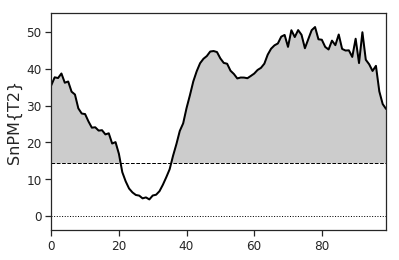

In [5]:
alpha = 0.05
iterations = 100

hotelling = spm1d.stats.nonparam.hotellings2(y_men, y_women)
hotellingi = hotelling.inference(alpha, iterations)

if hotellingi.h0reject:
    print(
        f'\th0 rejected, variables in women != in men (p={hotellingi.p})'
    )
else:
    print(
        f'\th0 not rejected, variables in women == in men (p={hotellingi.p})'
    )
hotellingi.plot()

In [6]:
# region of interest
def cluster_to_roi(clusters, time_vector=np.arange(100)):
    roi = np.zeros(time_vector.shape)
    for icluster in clusters:
        roi[int(icluster.endpoints[0]):int(icluster.endpoints[1])] = 1
    return roi

roi = cluster_to_roi(hotellingi.clusters)

## Post-hoc

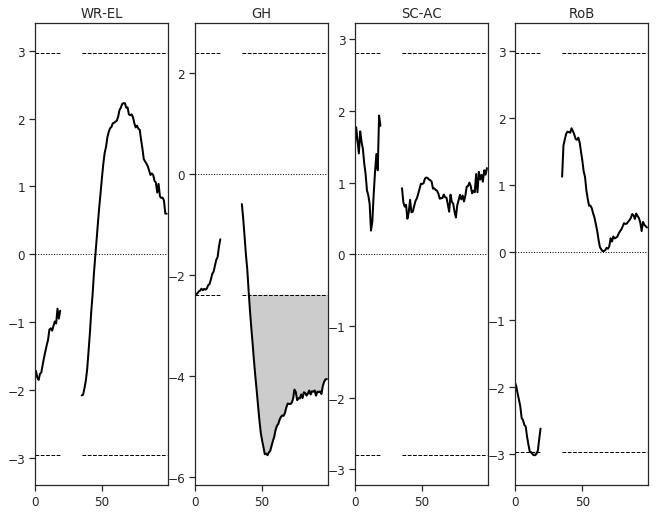

In [7]:
fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(11, 8.5))
t_testi = []
for i, idelta in enumerate(['WR-EL', 'GH', 'SC-AC', 'RoB']):
    t_test = spm1d.stats.nonparam.ttest2(
        y_men[..., i], y_women[..., i], roi=roi)
    t_testi.append(t_test.inference(alpha, iterations, two_tailed=True))

    t_testi[i].plot(ax=ax[i], plot_ylabel=False)
    ax[i].set_title(idelta)

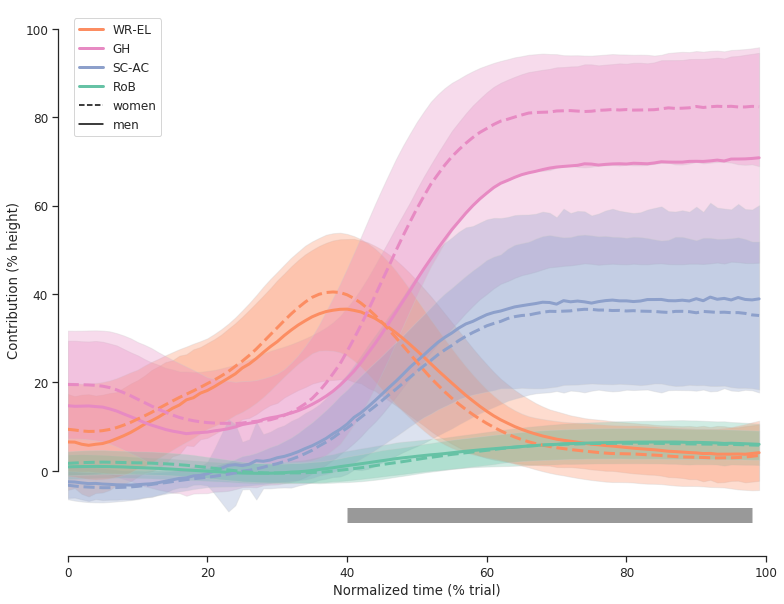

In [8]:
fig, ax = plt.subplots(figsize=(11, 8.5))

colors = {
    'WR-EL': '#fc8d62ff',
    'GH': '#e78ac3ff',
    'SC-AC': '#8da0cbff',
    'RoB': '#66c2a5ff'
}

spm1d.plot.plot_mean_sd(y_men[..., 0], linecolor=colors['WR-EL'], facecolor=colors['WR-EL'], alpha=.3, label='WR-EL')
spm1d.plot.plot_mean_sd(y_men[..., 1], linecolor=colors['GH'], facecolor=colors['GH'], alpha=.3, label='GH')
spm1d.plot.plot_mean_sd(y_men[..., 2], linecolor=colors['SC-AC'], facecolor=colors['SC-AC'], alpha=.3, label='SC-AC')
spm1d.plot.plot_mean_sd(y_men[..., 3], linecolor=colors['RoB'], facecolor=colors['RoB'], alpha=.3, label='RoB')

spm1d.plot.plot_mean_sd(y_women[..., 0], linecolor=colors['WR-EL'], facecolor=colors['WR-EL'], alpha=.3, linestyle='--')
spm1d.plot.plot_mean_sd(y_women[..., 1], linecolor=colors['GH'], facecolor=colors['GH'], alpha=.3, linestyle='--')
spm1d.plot.plot_mean_sd(y_women[..., 2], linecolor=colors['SC-AC'], facecolor=colors['SC-AC'], alpha=.3, linestyle='--')
spm1d.plot.plot_mean_sd(y_women[..., 3], linecolor=colors['RoB'], facecolor=colors['RoB'], alpha=.3, linestyle='--')

plt.plot([0, 0], [-1000, -1000], linestyle='--', color='k', alpha=1, label='women')
plt.plot([0, 0], [-1000, -1000], linestyle='-', color='k', alpha=1, label='men')

plt.plot([int(i) for i in t_testi[1].clusters[0].endpoints], [-10, -10], linewidth=15, solid_capstyle='butt', color='k', alpha=0.4)

plt.plot()

plt.legend(loc='upper left')

ax.set_ylabel('Contribution (% height)')
ax.set_xlabel('Normalized time (% trial)')
ax.xaxis.set_ticks(np.linspace(0, 100, num=6))

sns.despine(offset=10, trim=True)
fig.tight_layout()

fig.savefig(f'./share/fig/contributions.pdf', transparent=True)

plt.show()

In [9]:
[int(i) for i in t_testi[1].clusters[0].endpoints]

[40, 98]